# Tutorial on  Fine-Tuning BERT for Classification Tasks

# Running the notebook

This notebook is shared in `view only mode`. If you want to run the cells inside it, you should either:

- click on ` open in playground mode` in the `file` menu (your change won't be saved though)
- save a copy in your drive that you can open in `edit` mode to be able to save your changes.

## Introduction

## BERT

BERT (Bidirectional Encoder Representations from Transformers), released in late 2018, is the model we will use in this tutorial to provide readers with a better understanding of and practical guidance for using transfer learning models in NLP. BERT is a method of pretraining language representations that was used to create models that NLP practicioners can then download and use for free. You can either use these models to extract high quality language features from your text data, or you can fine-tune these models on a specific task (classification, entity recognition, question answering, etc.) with your own data to produce state of the art predictions.

### This Tutorial

This post will explain how you can modify and fine-tune BERT to create a powerful NLP model that quickly gives you state of the art results. 

### Why Fine-Tuning Rather Than Building New Model from Scartch ?

In this tutorial, we will use BERT to train a text classifier. Specifically, we will take the pre-trained BERT model, add an untrained layer of neurons on the end, and train the new model for our classification task. Why do this rather than train a train a specific deep learning model (a CNN, BiLSTM, etc.) that is well suited for the specific NLP task you need? 

#### Easy Training

First, the pre-trained BERT model weights already encode a lot of information about our language. As a result, it takes much less time to train our fine-tuned model - it is as if we have already trained the bottom layers of our network extensively and only need to gently tune them while using their output as features for our classification task. In fact, the authors recommend only 2-4 epochs of training for fine-tuning BERT on a specific NLP task (compared to the hundreds of GPU hours needed to train the original BERT model or a LSTM from scratch!). 

#### Less Data

In addition and perhaps just as important, because of the pre-trained weights this method allows us to fine-tune our task on a much smaller dataset than would be required in a model that is built from scratch. A major drawback of NLP models built from scratch is that we often need a prohibitively large dataset in order to train our network to reasonable accuracy, meaning a lot of time and energy had to be put into dataset creation. By fine-tuning BERT, we are now able to get away with training a model to good performance on a much smaller amount of training data.

#### Good Results

Second, this simple fine-tuning procedure (typically adding one fully-connected layer on top of BERT and training for a few epochs) was shown to achieve state of the art results with minimal task-specific adjustments for a wide variety of tasks: classification, language inference, semantic similarity, question answering, etc. Rather than implementing custom and sometimes-obscure architetures shown to work well on a specific task, simply fine-tuning BERT is shown to be a better (or at least equal) alternative.

#### A Shift in NLP

This shift to transfer learning parallels the same shift that took place in computer vision a few years ago. Creating a good deep learning network for computer vision tasks can take millions of parameters and be very expensive to train. Researchers discovered that deep networks learn hierarchical feature representations (simple features like edges at the lowest layers with gradually more complex features at higher layers). Rather than training a new network from scratch each time, the lower layers of a trained network with generalized image features could be copied and transfered for use in another network with a different task. It soon became common practice to download a pre-trained deep network and quickly retrain it for the new task or add additional layers on top - vastly preferable to the expensive process of training a network from scratch. For many, the introduction of deep pre-trained language models in 2018 (ELMO, BERT, ULMFIT, Open-GPT, etc.) signals the same shift to transfer learning in NLP that computer vision saw.

Let's get started!

## Install and Import

Google Colab offers free GPUs and TPUs! In casae we have a  large neural network it's best to take advantage of this (in this case we'll attach a GPU). For this tutorial you can also use CPU.

A GPU can be added by going to the menu and selecting:

Edit -> Notebook Settings -> Add accelerator (GPU)

Then run the following cell to confirm that the GPU is detected.

In [2]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Next, let's install the pytorch interface for BERT by Hugging Face. (This library contains interfaces for other pretrained language models like OpenAI's GPT and GPT-2.)


In [0]:
!pip install pytorch-transformers

In [4]:
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

Using TensorFlow backend.


**Importing some classes from pytorch_transformers**

In [0]:
from  pytorch_transformers import BertTokenizer, BertConfig
from pytorch_transformers import AdamW, WarmupLinearSchedule

In the case of using GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we need to load data onto the device. 

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla K80'

## Loading Dataset


We'll use The Corpus of Linguistic Acceptability (CoLA) dataset for single sentence classification. It's a set of sentences labeled as grammatically correct or incorrect. The data is as follows:

**Column 1**:	the code representing the source of the sentence.

**Column 2**:	the acceptability judgment label (0=unacceptable, 1=acceptable).

**Column 3**:	the acceptability judgment as originally notated by the author.

**Column 4**:	the sentence.

Download the dataset from this link, extract, and move them to your local drive.

https://nyu-mll.github.io/CoLA/

Both tokenized and raw versions of the data are available. We will use the **raw** version because we need to use the BERT tokenizer to break the text down into tokens and chunks that the model will recognize.

In [107]:
# Upload the train file from your local drive
from google.colab import files
uploaded = files.upload()

In [0]:
df = pd.read_csv("in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

In [8]:
df.shape

(8551, 4)

In [9]:
df.sample(5)

,sentence_source,label,label_notes,sentence
4240,ks08,0,*,The committee hasn't yet made up their mind.
2205,l-93,1,NaN,Tessa cut herself.
1502,r-67,1,NaN,It was tomorrow that I promised that he would ...
4608,ks08,1,NaN,The new policy was approved by the executive c...
5810,c_13,1,NaN,That automobile factories abound in Michigan w...


### Create sentence and label lists

To use BERT, We need to add special tokens at the beginning and end of each sentence for BERT to work properly

In [0]:
sentences = df.sentence.values
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

## Inputs

Next, import the BERT tokenizer, used to convert our text into tokens that correspond to BERT's vocabulary.

In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 2403996.19B/s]


Tokenize the first sentence:
['[CLS]', 'our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.', '[SEP]']


BERT requires specifically formatted inputs. For each tokenized input sentence, we need to create:

- **input ids**: a sequence of integers identifying each input token to its index number in the BERT tokenizer vocabulary
- **segment mask**: (optional) a sequence of 1s and 0s used to identify whether the input is one sentence or two sentences long. For one sentence inputs, this is simply a sequence of 0s. For two sentence inputs, there is a 0 for each token of the first sentence, followed by a 1 for each token of the second sentence
- **attention mask**: (optional) a sequence of 1s and 0s, with 1s for all input tokens and 0s for all padding tokens (we'll detail this in the next paragraph)
- **labels**: a single value of 1 or 0. In our task 1 means "grammatical" and 0 means "ungrammatical"

Although we can have variable length input sentences, BERT does requires our input arrays to be the same size. We address this by first choosing a maximum sentence length, and then padding and truncating our inputs until every input sequence is of the same length. 

In [0]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
# In the original paper, the authors used a length of 512.
MAX_LEN = 128

In [0]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [14]:
print(input_ids[0])

[101, 2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012, 102]


In [0]:
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [16]:
print(input_ids[0])

[  101  2256  2814  2180  1005  1056  4965  2023  4106  1010  2292  2894
  1996  2279  2028  2057 16599  1012   102     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]


Create the attention masks 

In [0]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [18]:
print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


Use train_test_split to split our data into train and validation sets for training

In [0]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [0]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [21]:
print(train_inputs.shape)

torch.Size([7695, 128])


Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32. Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory

In [0]:
batch_size = 16

# Training
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Validation
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


## Train Model

Now that our input data is properly formatted, it's time to fine tune the BERT model. 
For this task, we first want to modify the pre-trained BERT model to give outputs for classification, and then we want to continue training the model on our dataset until that the entire model, end-to-end, is well-suited for our task. So, what we need to do is to add a single classification layer on top of BERT model. As we feed input data, the entire pre-trained BERT's model and the additional untrained classification layer is trained on our specific task. Alternatively, we can freez all layers and just fine tune the classification head.

### Structure of Fine-Tuning Model

As we've showed beforehand, the first token of every sequence is the special classification token ([CLS]). Unlike the hidden state vector corresponding to a normal word token, the hidden state corresponding to this special token is designated by the authors of BERT as an aggregate representation of the whole sentence used for classification tasks. As such, when we feed in an input sentence to our model during training, the output is the length 768 hidden state vector corresponding to this token. The additional layer that we've added on top consists of untrained linear neurons of size [hidden_state, number_of_labels], so [768,2], meaning that the output of BERT plus our classification layer is a vector of two numbers representing the "score" for "grammatical/non-grammatical" that are then fed into cross-entropy loss.



### The Fine-Tuning Process

Because the pre-trained BERT layers already encode a lot of information about the language, training the classifier is relatively inexpensive. Rather than training every layer in a large model from scratch, it's as if we have already trained the bottom layers 95% of where they need to be, and only really need to train the top layer, with a bit of tweaking going on in the lower levels to accomodate our task.

Sometimes practicioners will opt to "freeze" certain layers when fine-tuning, or to apply different learning rates, apply diminishing learning rates, etc. all in an effort to preserve the good quality weights in the network and speed up training (often considerably). In fact, recent research on BERT specifically has demonstrated that freezing the majority of the weights results in only minimal accuracy declines, but there are exceptions and broader rules of transfer learning that should also be considered. For example, if your task and fine-tuning dataset is very different from the dataset used to train the transfer learning model, freezing the weights may not be a good idea. We'll cover the broader scope of transfer learning in NLP in a future post.  



There are a few different pre-trained BERT models available. "bert-base-uncased" means the version that has only lowercase letters ("uncased") and is the smaller version of the two ("base" vs "large").

**Adding a classification head**

In [0]:
from pytorch_transformers.modeling_bert import BertLayerNorm

In [0]:
class BertWithClfHead(nn.Module):
    def __init__(self, config, adapt_args, bertmodel):
        super().__init__()
        self.num_labels = adapt_args.num_classes
        self.config = config
        self.bert = bertmodel
        self.dropout = nn.Dropout(config['hidden_dropout_prob'])
        self.classifier = nn.Linear(config['hidden_size'], adapt_args.num_classes)
    
    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None, position_ids=None, head_mask=None):
        outputs = self.bert(input_ids, position_ids=position_ids, token_type_ids=token_type_ids,
                            attention_mask=attention_mask, head_mask=head_mask)
        
        pooled_output = outputs[1] # see note below

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        outputs = (logits,) + outputs[2:]  # add hidden states and attention if they are here

        if labels is not None:
            if self.num_labels == 1:
                #  We are doing regression
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1), labels.view(-1))
            else:
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            outputs = (loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)

Note that **pooled_output**: ``torch.FloatTensor``  is of shape ``(batch_size, hidden_size)``
            of last layer hidden-state of the first token of the sequence (clf token)
            further processed by a Linear layer and a Tanh activation function. The Linear
            layer weights are trained from the next sentence prediction (classification)
            objective during Bert pretraining. 

In [0]:
from collections import namedtuple
fine_tuning_config = namedtuple('fine_tuning_config',
  field_names="num_classes, lr, n_epochs, n_warmup")
adapt_args = fine_tuning_config(2, 2e-5, 5,10  )

In [0]:
from pytorch_transformers import BertModel
from pytorch_transformers import cached_path

In [26]:
bertconfig = cached_path("https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json")

100%|██████████| 313/313 [00:00<00:00, 131137.46B/s]


In [27]:
import json
with open(bertconfig, "r") as read_file:
    bertconfig = json.load(read_file)
print (bertconfig)


{'attention_probs_dropout_prob': 0.1, 'hidden_act': 'gelu', 'hidden_dropout_prob': 0.1, 'hidden_size': 768, 'initializer_range': 0.02, 'intermediate_size': 3072, 'max_position_embeddings': 512, 'num_attention_heads': 12, 'num_hidden_layers': 12, 'type_vocab_size': 2, 'vocab_size': 30522}


In [0]:
model = BertWithClfHead(bertconfig, adapt_args, BertModel.from_pretrained('bert-base-uncased'))
model.cuda()

Note that alternatively you can build your model by using the built in function in pytorch-transoformers, i.e., ```BertForSequenceClassification```

In [0]:
# alternatively you can use this
# from pytorch_transformers.modeling_bert import BertForSequenceClassification
# model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
# model.cuda()

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend the following hyperparameter ranges:
- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

In [0]:
# Parameters:
max_grad_norm = 1.0

### In PyTorch-Transformers, optimizer and schedules are splitted and instantiated like this:
optimizer = AdamW(model.parameters(), lr=adapt_args.lr, correct_bias=False)  # To reproduce BertAdam specific behavior set correct_bias=False
scheduler = WarmupLinearSchedule(optimizer, warmup_steps=adapt_args.n_warmup, t_total=len(train_dataloader)*adapt_args.n_epochs)  # PyTorch scheduler


Below is our training loop. For each pass in our loop we have a trianing phase and a validation phase. At each pass we need to:

Training loop:
- Tell the model to compute gradients by setting the model in train mode
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration (Optional)
- Clear out the gradients calculated in the previous pass. In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

Evalution loop:
- Tell the model not to compute gradients by setting th emodel in evaluation mode
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration (Optional)
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress


In [0]:
# Function to calculate the accuracy of our predictions vs labels
def predict_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [33]:
import sys
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = adapt_args.n_epochs

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
#     loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    outputs = model(input_ids=b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels, position_ids=None, head_mask=None)
    loss = outputs[0]
    train_loss_set.append(loss)    
    # Backward pass
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
    # Update parameters and take a step using the computed gradient
    scheduler.step()
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
#   Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
#     # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = predict_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.49131983518600464


Epoch:  20%|██        | 1/5 [06:29<25:57, 389.42s/it]

Validation Accuracy: 0.7893518518518519
Train loss: 0.24958764016628265


Epoch:  40%|████      | 2/5 [12:58<19:28, 389.37s/it]

Validation Accuracy: 0.8194444444444444
Train loss: 0.1411580592393875


Epoch:  60%|██████    | 3/5 [19:27<12:58, 389.12s/it]

Validation Accuracy: 0.8113425925925926
Train loss: 0.08739382773637772


Epoch:  80%|████████  | 4/5 [25:54<06:28, 388.70s/it]

Validation Accuracy: 0.8136574074074074
Train loss: 0.05052874609827995


Epoch: 100%|██████████| 5/5 [32:22<00:00, 388.25s/it]

Validation Accuracy: 0.8171296296296297


## Training Evaluation

Let's take a look at our training loss over all batches:

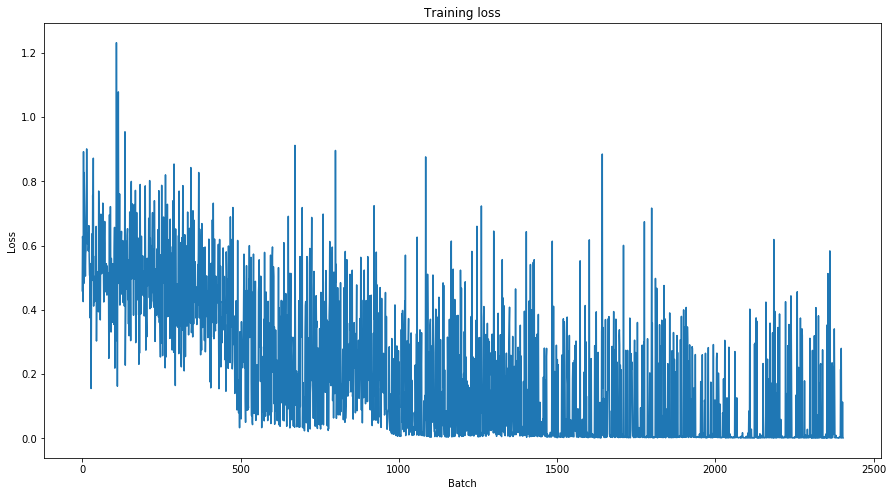

In [34]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

##Predict and Evaluate on Holdout Set

Now we'll load the holdout dataset and prepare inputs just as we did with the training set. Then we'll evaluate predictions using [Matthew's correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html) because this is the metric used by the wider NLP community to evaluate performance on CoLA. With this metric, +1 is the best score, and -1 is the worst score. This way, we can see how well we perform against the state of the art models for this specific task.

In [0]:
# Upload the test file from your local drive
from google.colab import files
uploaded = files.upload()


Saving out_of_domain_dev.tsv to out_of_domain_dev (1).tsv


In [0]:
df = pd.read_csv("out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 128
# Pad our input tokens
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 16  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [52]:
print(prediction_inputs.shape)
print(prediction_masks.shape)
print(prediction_labels.shape)

torch.Size([516, 128])
torch.Size([516, 128])
torch.Size([516])


In [0]:
# Prediction on test set
import sys

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
  # Move logits and labels to CPU
  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [57]:
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


The final score will be based on the entire test set, but let's take a look at the scores on the individual batches to get a sense of the variability in the metric between batches.


In [58]:
matthews_set

[0.2581988897471611,
 -0.17407765595569785,
 -0.18156825980064073,
 -0.2277100170213244,
 -0.29277002188455997,
 0.8783100656536799,
 0.5606119105813882,
 -0.2182178902359924,
 -0.29277002188455997,
 0.8563488385776753,
 0.6180700462007377,
 0.7453559924999299,
 0.5163977794943222,
 0.6201736729460423,
 0.4472135954999579,
 0.0,
 0.8320502943378436,
 1.0,
 0.7777777777777778,
 0.8783100656536799,
 0.8563488385776753,
 0.6546536707079772,
 0.7453559924999299,
 0.6546536707079772,
 0.6831300510639732,
 1.0,
 1.0,
 0.4472135954999579,
 0.30261376633440124,
 0.09245003270420485,
 0.32277655457716287,
 0.6546536707079772,
 0.0]

In [0]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]


In [60]:
matthews_corrcoef(flat_true_labels, flat_predictions)

0.5059672171779087

Great! In a short amount of time without doing any hyperparameter tuning, we were able to get a relatively good score. Also note that we didn't train on the entire training dataset, but set aside a portion of it as our validation set.

If you look at the GLUE leaderboard [here](https://gluebenchmark.com/leaderboard/submission/zlssuBTm5XRs0aSKbFYGVIVdvbj1/-LhijX9VVmvJcvzKymxy), you'll see that our score (50.1) using the small version of BERT is not too far from the BERT authors' CoLA score (60.5) with the same model. If you want to tune the hyperparameters, use the entire train set, or use the larger BERT model instead you're likely able to push that score up higher into the mid- 60s, which looks like the state of the art as of August 2019!


## Conclusion

This post showed that with a pre-trained BERT model you can quickly and effectively develope a new model by fine tuning BERT model for your specific task.


In [0]:
# i.e., # if you run out of memory
# !pkill -9 -f ipykernel_launcher